# 03. EDS biasing using HTF

Here the collective variable (CV) being biased is the average distance to center of mass.

In [1]:
import hoomd
import hoomd.md
import hoomd.dump
import hoomd.group
import hoomd.htf as htf
import tensorflow as tf
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Build the computational graph

We first create a CV, the distance from the center of mass for each atom. Then we use EDS to bias the CV to match our target value. Note we add the forces ourselves to the compute graph and they depend on the atom positions, not the distance between atoms.

In [2]:
class EDSModel(htf.SimModel):
    def setup(self, set_point):
        self.cv_avg = tf.keras.metrics.Mean()
        self.eds_bias = htf.EDSLayer(set_point, period=25, learning_rate=5.0)

    def compute(self, nlist, positions):
        #calculate center of mass
        com = tf.reduce_mean(positions[:, :2], 0) 
        #calculate distance of each atom from center of mass
        rs = tf.norm(positions[:, :2] - com, axis=1)
        #calculate the average distance from center of mass. This is the collective variable (CV)
        real_cv = tf.reduce_mean(rs) 
        self.cv_avg.update_state(real_cv)
        alpha = self.eds_bias(real_cv)
        # eds + harmonic bond
        energy = real_cv * alpha
        forces = htf.compute_positions_forces(positions, energy)
        return forces, real_cv, self.cv_avg.result(), alpha
model = EDSModel(0, set_point=4.0)

## Running the simulation

This simulation is 64 LJ particles in an NVT ensemble. We save data every 250 steps.

In [3]:
#### Hoomd-Sim code ####

hoomd.context.initialize("--mode=cpu")
tfcompute = htf.tfcompute(model)
#cut off radius: must be less than the box size
rcut = 6.0 
#initialize the lattice
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=2.0),n=[8, 8])
nlist = hoomd.md.nlist.cell(check_period=1)
#enable lj pair potential
lj = hoomd.md.pair.lj(rcut, nlist) 
#set lj coefficients
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) 
hoomd.md.integrate.mode_standard(dt=0.005)
# set up NVT simulation
hoomd.md.integrate.nvt(kT=1.0, tau=0.5,group=hoomd.group.all()) 
#equilibrate
hoomd.run(3000)
#simulation
tfcompute.attach(nlist, r_cut=rcut, save_output_period=250)
hoomd.run(15000)

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 64 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 64
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:00 | Step 3000 / 3000 | TPS 

## Analysis

Now we plot the CV value and its running average to assess if EDS converged

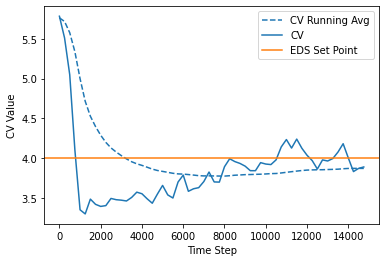

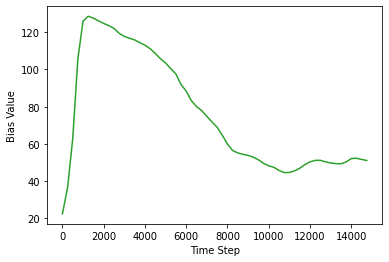

In [6]:
import matplotlib.pyplot as plt
import numpy as np 
time = range(0, 15000, 250)
plt.plot(time, tfcompute.outputs[1], label='CV Running Avg', linestyle='--')
plt.plot(time, tfcompute.outputs[0], label='CV', color='C0')
plt.axhline(4.0, label='EDS Set Point', color='C1')
plt.ylabel('CV Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()
plt.plot(time,  tfcompute.outputs[2], label='Bias', color='C2')
plt.ylabel('Bias Value')
plt.xlabel('Time Step')
plt.show()